In [13]:
#打印文件夹结构
import os
def print_dir(path,level=0):
    if not os.path.isdir(path):
        return
    for i in os.listdir(path):
        print("|  " * level + "|--" + i)
        if os.path.isdir(path + "/" + i):
            print_dir(path + "/" + i,level+1)
if __name__ == "__main__":
    path = input("请输入文件夹路径:")
    print_dir(path)
    

|--100.atr
|--100.dat
|--100.hea
|--100.xws
|--101.atr
|--101.dat
|--101.hea
|--101.xws
|--102-0.atr
|--102.atr
|--102.dat
|--102.hea
|--102.xws
|--103.atr
|--103.dat
|--103.hea
|--103.xws
|--104.atr
|--104.dat
|--104.hea
|--104.xws
|--105.atr
|--105.dat
|--105.hea
|--105.xws
|--106.atr
|--106.dat
|--106.hea
|--106.xws
|--107.atr
|--107.dat
|--107.hea
|--107.xws
|--108.atr
|--108.at_
|--108.dat
|--108.hea
|--108.xws
|--109.atr
|--109.dat
|--109.hea
|--109.xws
|--111.atr
|--111.dat
|--111.hea
|--111.xws
|--112.atr
|--112.dat
|--112.hea
|--112.xws
|--113.atr
|--113.dat
|--113.hea
|--113.xws
|--114.atr
|--114.dat
|--114.hea
|--114.xws
|--115.atr
|--115.dat
|--115.hea
|--115.xws
|--116.atr
|--116.dat
|--116.hea
|--116.xws
|--117.atr
|--117.at_
|--117.dat
|--117.hea
|--117.xws
|--118.atr
|--118.dat
|--118.hea
|--118.xws
|--119.atr
|--119.at_
|--119.dat
|--119.hea
|--119.xws
|--121.atr
|--121.dat
|--121.hea
|--121.xws
|--122.atr
|--122.dat
|--122.hea
|--122.xws
|--123.atr
|--123.dat
|--123.h

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


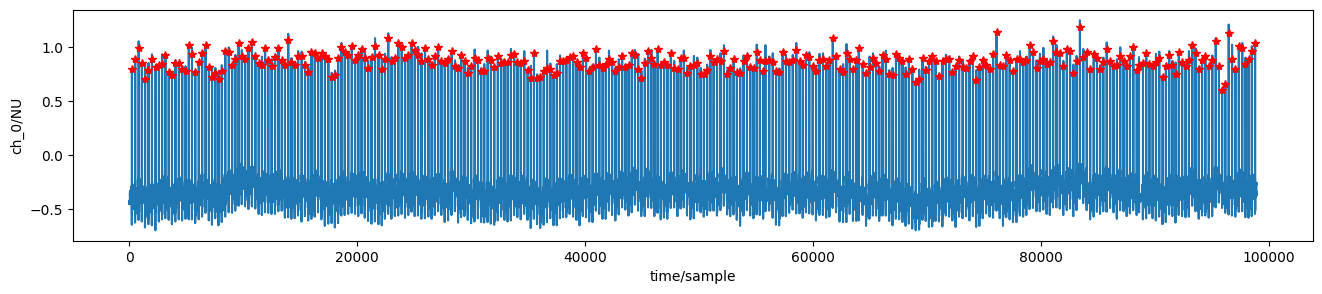

R-R interval in ms: [802.77777778 833.33333333 794.44444444 786.11111111 819.44444444
 847.22222222 880.55555556 822.22222222 775.         805.55555556
 811.11111111 797.22222222 836.11111111 830.55555556 825.
 811.11111111 788.88888889 780.55555556 808.33333333 841.66666667
 833.33333333 830.55555556 805.55555556 775.         797.22222222
 783.33333333 791.66666667 855.55555556 847.22222222 822.22222222
 783.33333333 786.11111111 786.11111111 816.66666667 811.11111111
 850.         833.33333333 811.11111111 780.55555556 775.
 786.11111111 802.77777778 841.66666667 825.         811.11111111
 777.77777778 800.         788.88888889 800.         816.66666667
 858.33333333 827.77777778 788.88888889 783.33333333 791.66666667
 830.55555556 825.         830.55555556 830.55555556 819.44444444
 800.         777.77777778 794.44444444 813.88888889 858.33333333
 847.22222222 811.11111111 794.44444444 786.11111111 797.22222222
 811.11111111 825.         847.22222222 852.77777778 805.55555556
 769.4

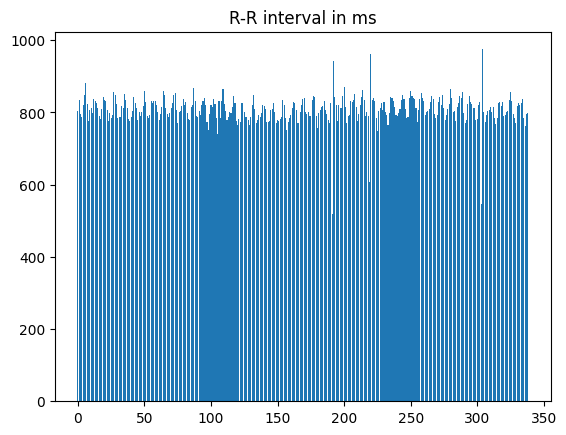

In [11]:
import wfdb
from scipy.signal import sosfiltfilt, butter
from wfdb.processing import XQRS
import numpy as np
from matplotlib import pyplot as plt

# Step 1: Read the data
afdb_dir = r"C:\Users\tkt21\OneDrive\桌面\课程项目论文\期末考核\mit-bih-arrhythmia-database-1.0.0"
record_name = '100'
record_name = f"{afdb_dir}\\{record_name}"
record = wfdb.rdrecord(record_name)

# Step 2: Read a segment of the data
sampfrom = 10960
sampto = 109900
record = wfdb.rdrecord(record_name, sampfrom=sampfrom, sampto=sampto)

# Extract the signal for ECG1
signal = record.p_signal.T[0]

# Step 3: Preprocess the data (filtering)
filter = butter(3, [5, 20], btype='bandpass', output='sos', fs=record.fs)
signal_filtered = sosfiltfilt(filter, signal)

# Step 4: QRS detection
def xqrs_detector(signal: np.ndarray) -> np.ndarray:
    xqrs = XQRS(signal, fs=record.fs)
    xqrs.detect()
    return xqrs.qrs_inds

qrs_location = xqrs_detector(signal_filtered)

# Step 5: Visualization
wfdb.plot_items(signal, ann_samp=[qrs_location], figsize=(16, 3))

# Step 6: Calculate RR intervals
rri = np.diff(qrs_location)
rri_ms = rri / record.fs * 1000
print('R-R interval in ms:', rri_ms)

# Plot RR intervals
plt.bar(range(len(rri_ms)), rri_ms)
plt.title("R-R interval in ms")
plt.show()


In [3]:
import os
import numpy as np
import wfdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import sosfiltfilt, butter
from wfdb.processing import XQRS
from matplotlib import pyplot as plt
from tqdm import tqdm  # 添加进度条库

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义解压数据集的路径
data_path = r"C:\Users\tkt21\OneDrive\桌面\课程项目论文\期末考核\mit-bih-arrhythmia-database-1.0.0"

# 读取ECG信号文件的函数
def load_ecg_signal(record_name):
    record = wfdb.rdrecord(os.path.join(data_path, record_name))
    ecg_signal = record.p_signal[:, 0]  # 使用第一个导联信号
    return ecg_signal

# 标准化ECG信号的函数
def normalize_ecg_signal(ecg_signal):
    mean = np.mean(ecg_signal)
    std = np.std(ecg_signal)
    normalized_signal = (ecg_signal - mean) / std
    return normalized_signal

# 分割ECG信号的函数
def segment_ecg_signal(ecg_signal, segment_length=5000):
    segments = [ecg_signal[i:i + segment_length] for i in range(0, len(ecg_signal), segment_length) if len(ecg_signal[i:i + segment_length]) == segment_length]
    return segments

# 滤波函数
def preprocess_signal(signal):
    filter = butter(3, [5, 20], btype='bandpass', output='sos', fs=250)  # 采样率fs设为250Hz
    signal_filtered = sosfiltfilt(filter, signal)
    return signal_filtered

# QRS检测函数
def xqrs_detector(signal, fs):
    xqrs = XQRS(signal, fs=fs)
    xqrs.detect()
    return xqrs.qrs_inds

# 可视化ECG信号及R峰位置
def visualize_signal(signal, rpeak_positions):
    plt.figure(figsize=(16, 6))
    plt.plot(signal, label='ECG Signal')
    plt.scatter(rpeak_positions, signal[rpeak_positions], color='red', label='R-peaks')
    plt.legend()
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()

# 加载所有文件并创建训练数据
all_ecg_segments = []
all_labels = []

# 使用tqdm显示进度条
for filename in tqdm(os.listdir(data_path), desc="Processing files"):
    if filename.endswith('.dat'):
        record_name = filename.split('.')[0]
        try:
            # 加载和标准化ECG信号
            ecg_signal = load_ecg_signal(record_name)
            normalized_ecg_signal = normalize_ecg_signal(ecg_signal)
            
            # 预处理信号
            filtered_signal = preprocess_signal(normalized_ecg_signal)
            
            # QRS检测
            rpeak_positions = xqrs_detector(filtered_signal, fs=250)
            
            # 创建标签
            labels = np.zeros(len(normalized_ecg_signal))
            labels[rpeak_positions] = 1
            
            # 分割信号和标签
            ecg_segments = segment_ecg_signal(filtered_signal)
            label_segments = segment_ecg_signal(labels)
            
            all_ecg_segments.extend(ecg_segments)
            all_labels.extend(label_segments)
            
            # 可视化部分信号和R峰位置（选取部分数据进行可视化）
            if len(all_ecg_segments) < 5:  # 仅可视化前5个文件
                visualize_signal(filtered_signal, rpeak_positions)
        except Exception as e:
            print(f"Error processing {record_name}: {e}")

# 转换为PyTorch张量
x_train_tensor = torch.tensor(np.array(all_ecg_segments).reshape(-1, 1, 5000), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(np.array(all_labels).reshape(-1, 1, 5000), dtype=torch.float32).to(device)

# 创建DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

print("Data preparation complete. Ready for model training.")


Processing files:   0%|          | 0/208 [00:00<?, ?it/s]

Learning initial signal parameters...


Processing files:   1%|          | 2/208 [00:01<02:10,  1.58it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:   3%|▎         | 6/208 [00:02<01:18,  2.56it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:   5%|▌         | 11/208 [00:03<01:00,  3.24it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:   7%|▋         | 15/208 [00:04<01:00,  3.21it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:   9%|▉         | 19/208 [00:06<00:57,  3.28it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  11%|█         | 23/208 [00:07<00:55,  3.32it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  13%|█▎        | 27/208 [00:08<00:53,  3.36it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  15%|█▍        | 31/208 [00:09<00:52,  3.36it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  17%|█▋        | 36/208 [00:10<00:47,  3.66it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  19%|█▉        | 40/208 [00:12<00:47,  3.56it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  21%|██        | 44/208 [00:13<00:46,  3.49it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  23%|██▎       | 48/208 [00:14<00:46,  3.45it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  25%|██▌       | 52/208 [00:15<00:45,  3.40it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  27%|██▋       | 56/208 [00:16<00:44,  3.43it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  29%|██▉       | 60/208 [00:17<00:43,  3.43it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  31%|███       | 64/208 [00:19<00:42,  3.38it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  33%|███▎      | 69/208 [00:20<00:38,  3.65it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  35%|███▌      | 73/208 [00:21<00:37,  3.62it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  38%|███▊      | 78/208 [00:22<00:34,  3.82it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  39%|███▉      | 82/208 [00:23<00:33,  3.71it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  41%|████▏     | 86/208 [00:24<00:33,  3.60it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  43%|████▎     | 90/208 [00:26<00:33,  3.54it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  45%|████▌     | 94/208 [00:27<00:32,  3.52it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  47%|████▋     | 98/208 [00:28<00:31,  3.50it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  49%|████▉     | 102/208 [00:29<00:30,  3.47it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  51%|█████     | 106/208 [00:30<00:29,  3.44it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  54%|█████▍    | 112/208 [00:32<00:24,  3.94it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  56%|█████▌    | 116/208 [00:33<00:24,  3.74it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  58%|█████▊    | 120/208 [00:34<00:23,  3.67it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  60%|█████▉    | 124/208 [00:35<00:23,  3.57it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  62%|██████▏   | 129/208 [00:36<00:21,  3.76it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  64%|██████▍   | 133/208 [00:37<00:20,  3.64it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  66%|██████▌   | 137/208 [00:39<00:19,  3.55it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  68%|██████▊   | 141/208 [00:40<00:19,  3.48it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  70%|███████   | 146/208 [00:41<00:16,  3.70it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  73%|███████▎  | 151/208 [00:42<00:14,  3.85it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  75%|███████▍  | 155/208 [00:43<00:14,  3.71it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  76%|███████▋  | 159/208 [00:45<00:13,  3.59it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  78%|███████▊  | 163/208 [00:46<00:12,  3.53it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  80%|████████  | 167/208 [00:47<00:11,  3.44it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  83%|████████▎ | 172/208 [00:48<00:09,  3.70it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  85%|████████▍ | 176/208 [00:49<00:08,  3.61it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  87%|████████▋ | 180/208 [00:51<00:07,  3.57it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  88%|████████▊ | 184/208 [00:52<00:06,  3.50it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  90%|█████████ | 188/208 [00:53<00:05,  3.51it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  92%|█████████▏| 192/208 [00:54<00:04,  3.46it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files:  94%|█████████▍| 196/208 [00:55<00:03,  3.44it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Processing files: 100%|██████████| 208/208 [00:56<00:00,  3.65it/s]

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Data preparation complete. Ready for model training.


In [20]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义U-Net模型
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=13, padding=6), # 13x1 卷积
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = CBR(1, 16)
        self.encoder2 = CBR(16, 32)
        self.encoder3 = CBR(32, 64)
        
        self.pool = nn.MaxPool1d(2, 2)
        
        self.decoder3 = CBR(96, 32)  # 修改此处，确保输入通道数为96 (64 + 32)
        self.decoder2 = CBR(48, 16)  # 修改此处，确保输入通道数为48 (32 + 16)
        self.decoder1 = nn.Conv1d(16, 1, kernel_size=1) # 1x1 卷积
        
        self.upsample = nn.ConvTranspose1d(64, 64, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose1d(32, 32, kernel_size=2, stride=2)

    def forward(self, x):
        # 编码路径
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        
        # 解码路径
        d3 = self.upsample(e3)
        d3 = torch.cat((d3, e2), dim=1)  # 拼接跳跃连接
        d3 = self.decoder3(d3)
        
        d2 = self.upsample2(d3)
        d2 = torch.cat((d2, e1), dim=1)  # 拼接跳跃连接
        d2 = self.decoder2(d2)
        
        d1 = self.decoder1(d2)
        
        return torch.sigmoid(d1)

# 检查数据是否加载正确
print(f"Number of ECG segments: {len(all_ecg_segments)}")
print(f"Number of labels: {len(all_labels)}")

if len(all_ecg_segments) == 0 or len(all_labels) == 0:
    raise ValueError("No data found in all_ecg_segments or all_labels")

# 准备数据
import numpy as np

all_ecg_segments = np.array(all_ecg_segments)
all_labels = np.array(all_labels)

x_train_tensor = torch.tensor(all_ecg_segments.reshape(-1, 1, 5000), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(all_labels.reshape(-1, 1, 5000), dtype=torch.float32).to(device)


# 打印张量的形状以确认正确性
print(f"x_train_tensor shape: {x_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

# 创建DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 初始化模型、损失函数和优化器
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model defined and data prepared for training.")

# 训练模型
num_epochs = 10  # 设定训练轮数
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Model training complete.")


Number of ECG segments: 6240
Number of labels: 6240
x_train_tensor shape: torch.Size([6240, 1, 5000])
y_train_tensor shape: torch.Size([6240, 1, 5000])
Model defined and data prepared for training.
Epoch [1/10], Loss: 0.1757
Epoch [2/10], Loss: 0.0233
Epoch [3/10], Loss: 0.0080
Epoch [4/10], Loss: 0.0043
Epoch [5/10], Loss: 0.0029
Epoch [6/10], Loss: 0.0022
Epoch [7/10], Loss: 0.0018
Epoch [8/10], Loss: 0.0016
Epoch [9/10], Loss: 0.0014
Epoch [10/10], Loss: 0.0013
Model training complete.


In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义U-Net模型
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=13, padding=6), # 13x1 卷积
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = CBR(1, 16)
        self.encoder2 = CBR(16, 32)
        self.encoder3 = CBR(32, 64)
        
        self.pool = nn.MaxPool1d(2, 2)
        
        self.decoder3 = CBR(96, 32)  # 修改此处，确保输入通道数为96 (64 + 32)
        self.decoder2 = CBR(48, 16)  # 修改此处，确保输入通道数为48 (32 + 16)
        self.decoder1 = nn.Conv1d(16, 1, kernel_size=1) # 1x1 卷积
        
        self.upsample = nn.ConvTranspose1d(64, 64, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose1d(32, 32, kernel_size=2, stride=2)

    def forward(self, x):
        # 编码路径
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        
        # 解码路径
        d3 = self.upsample(e3)
        d3 = torch.cat((d3, e2), dim=1)  # 拼接跳跃连接
        d3 = self.decoder3(d3)
        
        d2 = self.upsample2(d3)
        d2 = torch.cat((d2, e1), dim=1)  # 拼接跳跃连接
        d2 = self.decoder2(d2)
        
        d1 = self.decoder1(d2)
        
        return torch.sigmoid(d1)

# 准备数据
all_ecg_segments = np.array(all_ecg_segments)
all_labels = np.array(all_labels)

x_train_tensor = torch.tensor(all_ecg_segments.reshape(-1, 1, 5000), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(all_labels.reshape(-1, 1, 5000), dtype=torch.float32).to(device)

# 创建DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 初始化模型、损失函数和优化器
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model defined and data prepared for training.")

# 训练模型
num_epochs = 100  # 设定训练轮数
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Model training complete.")

# 评估模型
model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for inputs, labels in train_loader:
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")


Model defined and data prepared for training.
Epoch [1/100], Loss: 0.1576
Epoch [2/100], Loss: 0.0188
Epoch [3/100], Loss: 0.0068
Epoch [4/100], Loss: 0.0038
Epoch [5/100], Loss: 0.0027
Epoch [6/100], Loss: 0.0021
Epoch [7/100], Loss: 0.0018
Epoch [8/100], Loss: 0.0015
Epoch [9/100], Loss: 0.0014
Epoch [10/100], Loss: 0.0013
Epoch [11/100], Loss: 0.0012
Epoch [12/100], Loss: 0.0011
Epoch [13/100], Loss: 0.0010
Epoch [14/100], Loss: 0.0010
Epoch [15/100], Loss: 0.0010
Epoch [16/100], Loss: 0.0010
Epoch [17/100], Loss: 0.0009
Epoch [18/100], Loss: 0.0009
Epoch [19/100], Loss: 0.0009
Epoch [20/100], Loss: 0.0009
Epoch [21/100], Loss: 0.0009
Epoch [22/100], Loss: 0.0008
Epoch [23/100], Loss: 0.0008
Epoch [24/100], Loss: 0.0009
Epoch [25/100], Loss: 0.0008
Epoch [26/100], Loss: 0.0007
Epoch [27/100], Loss: 0.0007
Epoch [28/100], Loss: 0.0008
Epoch [29/100], Loss: 0.0008
Epoch [30/100], Loss: 0.0007
Epoch [31/100], Loss: 0.0007
Epoch [32/100], Loss: 0.0008
Epoch [33/100], Loss: 0.0007
Epoch 

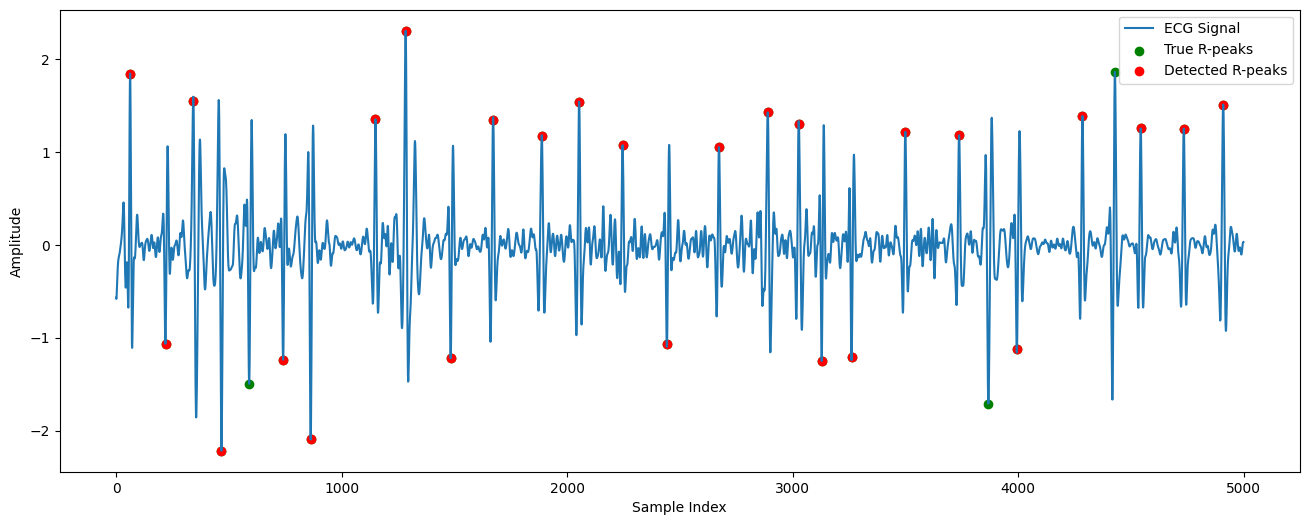

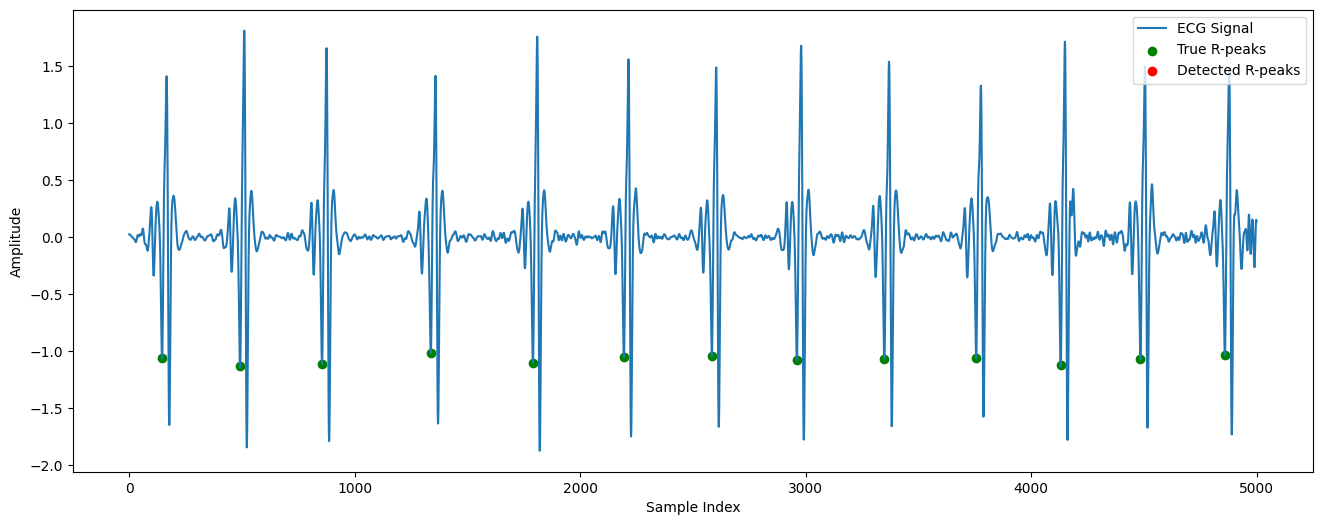

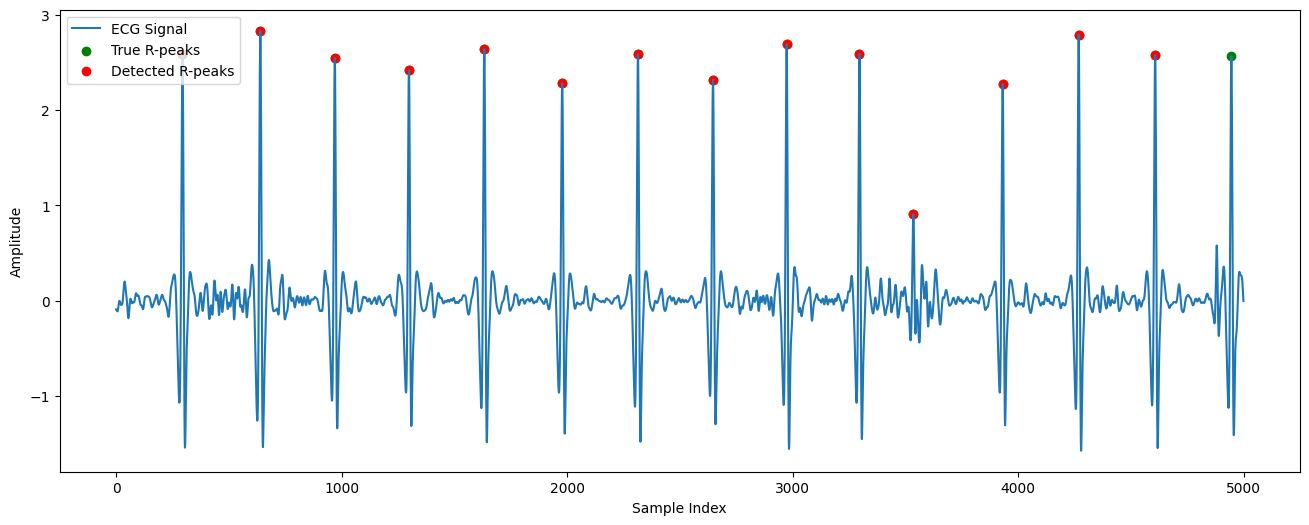

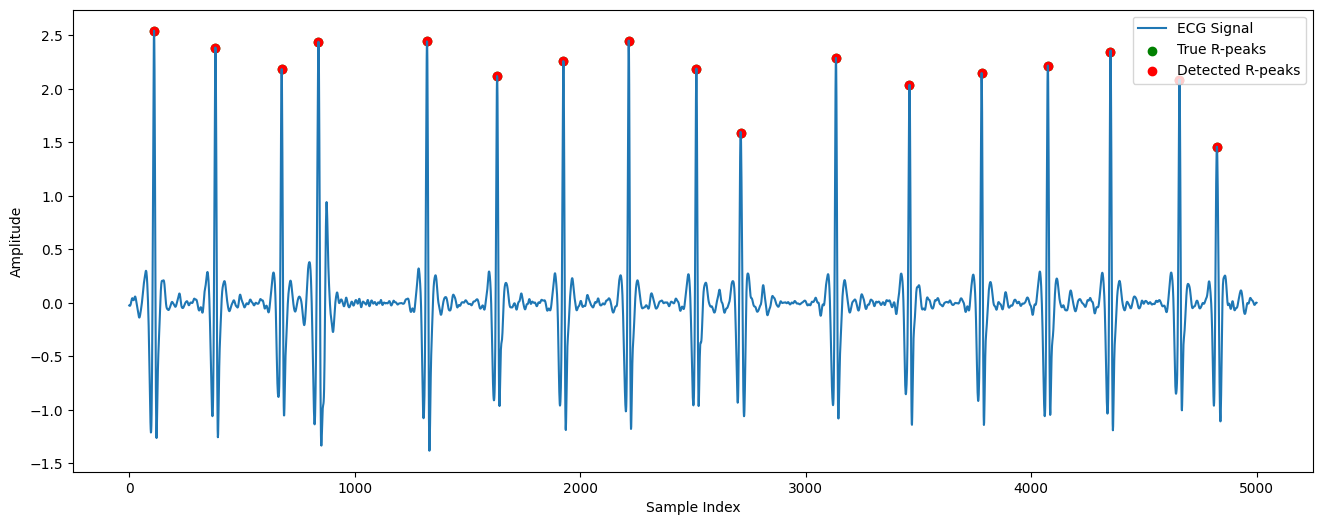

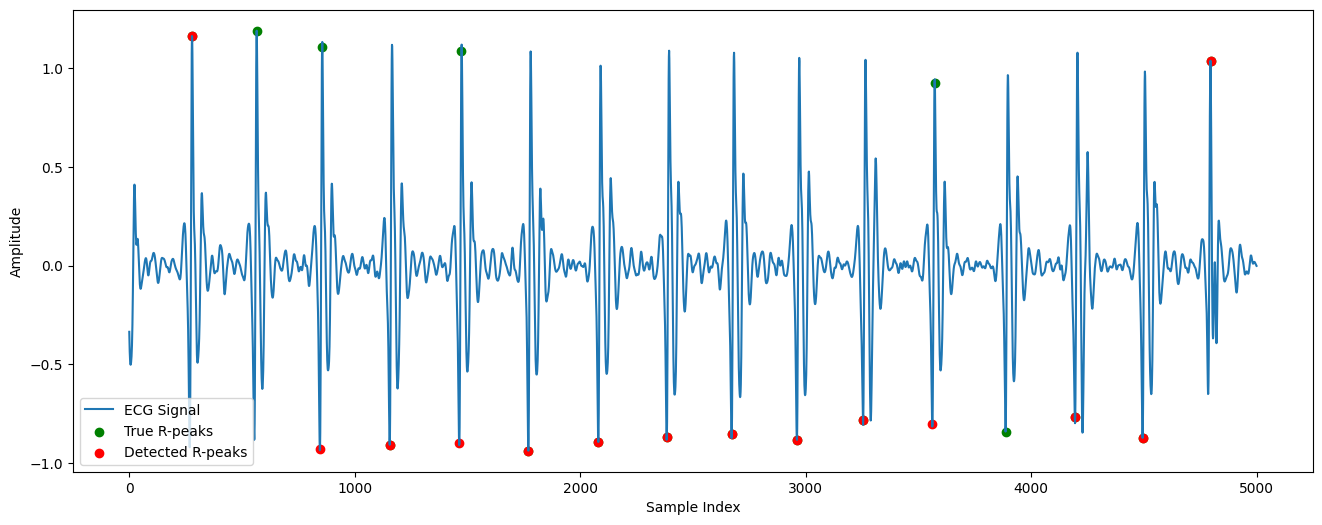

Average Sensitivity: 0.9282
Average Positive Predictivity: 0.9924
Average Accuracy: 0.9276
Average F1 Score: 0.9540


In [5]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 对U-Net模型输出进行二值化
def binarize_output(output, threshold=0.9):
    return (output > threshold).astype(np.float32)

# 使用DBSCAN进行聚类
def apply_dbscan(binary_output, eps=50, min_samples=1):
    # 将二值化输出展开为一维
    points = np.argwhere(binary_output.flatten() == 1).flatten().reshape(-1, 1)
    if len(points) == 0:
        return points, np.array([])  # 返回空结果以避免错误
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(points)
    return points, labels

# 找到每个聚类的中间点
def find_r_peaks(points, labels):
    r_peaks = []
    for label in np.unique(labels):
        if label == -1:  # 噪声点
            continue
        cluster_points = points[labels == label]
        r_peak = cluster_points[len(cluster_points) // 2]  # 中间点
        r_peaks.append(r_peak[0])
    return r_peaks

# 评估模型性能
def evaluate_performance(true_peaks, detected_peaks, tolerance=75):
    tp = 0
    fp = 0
    fn = 0
    
    for true_peak in true_peaks:
        if any(np.abs(true_peak - detected_peak) <= tolerance for detected_peak in detected_peaks):
            tp += 1
        else:
            fn += 1
    
    for detected_peak in detected_peaks:
        if not any(np.abs(detected_peak - true_peak) <= tolerance for true_peak in true_peaks):
            fp += 1
    
    # 避免分母为零的情况
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    positive_predictivity = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    f1 = 2 * (sensitivity * positive_predictivity) / (sensitivity + positive_predictivity) if (sensitivity + positive_predictivity) > 0 else 0
    
    return sensitivity, positive_predictivity, accuracy, f1

# 可视化R峰检测
def visualize_r_peak_detection(signal, true_peaks, detected_peaks):
    plt.figure(figsize=(16, 6))
    plt.plot(signal, label='ECG Signal')
    plt.scatter(true_peaks, signal[true_peaks], color='green', label='True R-peaks')
    plt.scatter(detected_peaks, signal[detected_peaks], color='red', label='Detected R-peaks')
    plt.legend()
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()

# 使用训练好的模型进行预测并评估性能
model.eval()
all_sensitivities = []
all_positive_predictivities = []
all_accuracies = []
all_f1_scores = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs).cpu().numpy()
        binary_outputs = binarize_output(outputs)
        
        for i in range(len(inputs)):
            points, cluster_labels = apply_dbscan(binary_outputs[i][0])
            detected_peaks = find_r_peaks(points, cluster_labels)
            true_peaks = np.argwhere(labels[i][0].cpu().numpy() == 1).flatten()
            
            sensitivity, positive_predictivity, accuracy, f1 = evaluate_performance(true_peaks, detected_peaks)
            all_sensitivities.append(sensitivity)
            all_positive_predictivities.append(positive_predictivity)
            all_accuracies.append(accuracy)
            all_f1_scores.append(f1)
            
            # 可视化R峰检测（仅可视化前几个样本以避免过多图形）
            if len(all_sensitivities) <= 5:
                visualize_r_peak_detection(inputs[i][0].cpu().numpy(), true_peaks, detected_peaks)

print(f"Average Sensitivity: {np.mean(all_sensitivities):.4f}")
print(f"Average Positive Predictivity: {np.mean(all_positive_predictivities):.4f}")
print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(all_f1_scores):.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=1; total time=   2.7s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=1; total time=   2.5s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=1; total time=   2.5s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=2; total time=   2.7s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=2; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=2; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=3; total time=   2.8s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=3; total time=   2.8s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=3; total time=   2.8s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=5; total time=   2.8s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=5; total time=   2.8s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=30, min_samples=5; total time=   2.8s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=1; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=1; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=1; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=2; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=2; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=2; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=3; total time=   3.2s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=3; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=3; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=5; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=5; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=40, min_samples=5; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=1; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=1; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=1; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=2; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=2; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=2; total time=   3.2s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=3; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=3; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=3; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=5; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=5; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=50, min_samples=5; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=1; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=1; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=1; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=2; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=2; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=2; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=3; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=3; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=3; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=5; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=5; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=60, min_samples=5; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=1; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=1; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=1; total time=   2.9s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=2; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=2; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=2; total time=   3.2s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=3; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=3; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=3; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=5; total time=   3.0s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=5; total time=   3.1s


C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkt21\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[CV] END ..............................eps=70, min_samples=5; total time=   3.0s
Best parameters: {'eps': 30, 'min_samples': 1}
Best score: nan


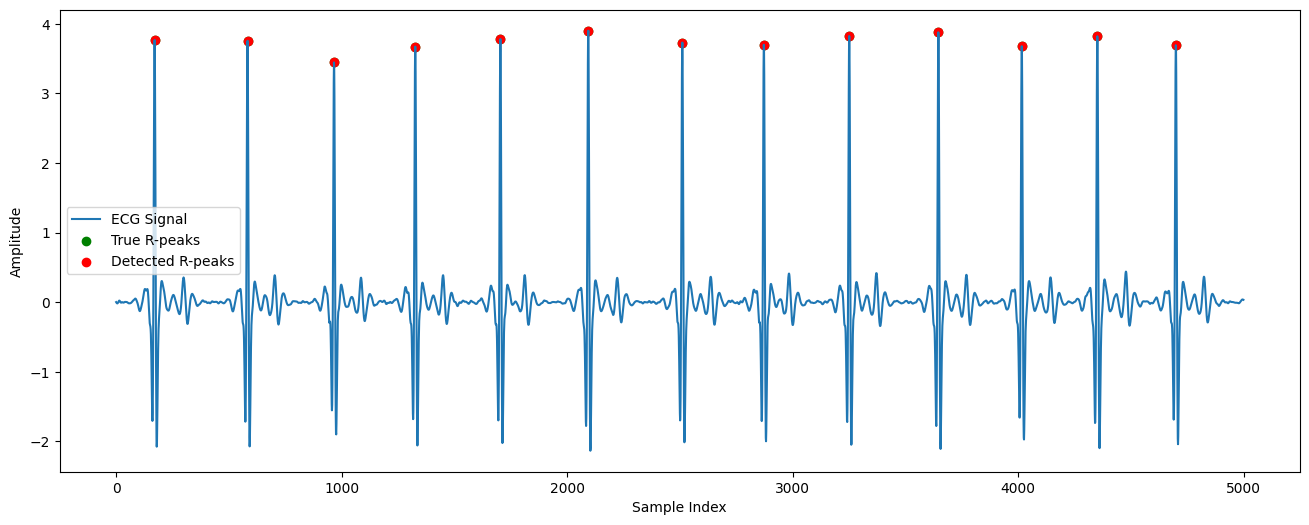

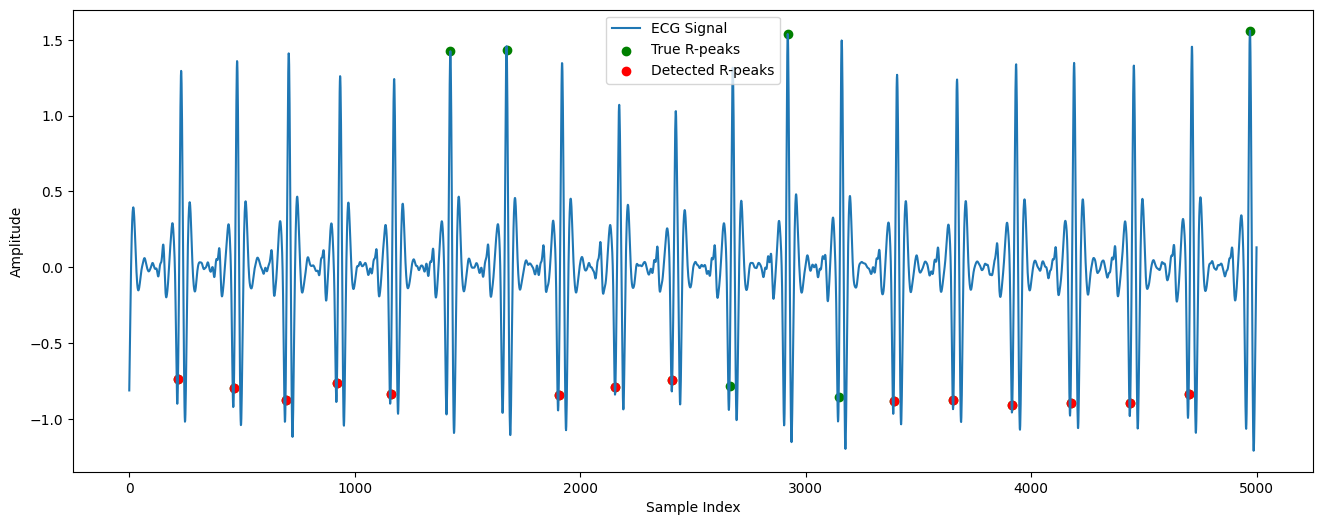

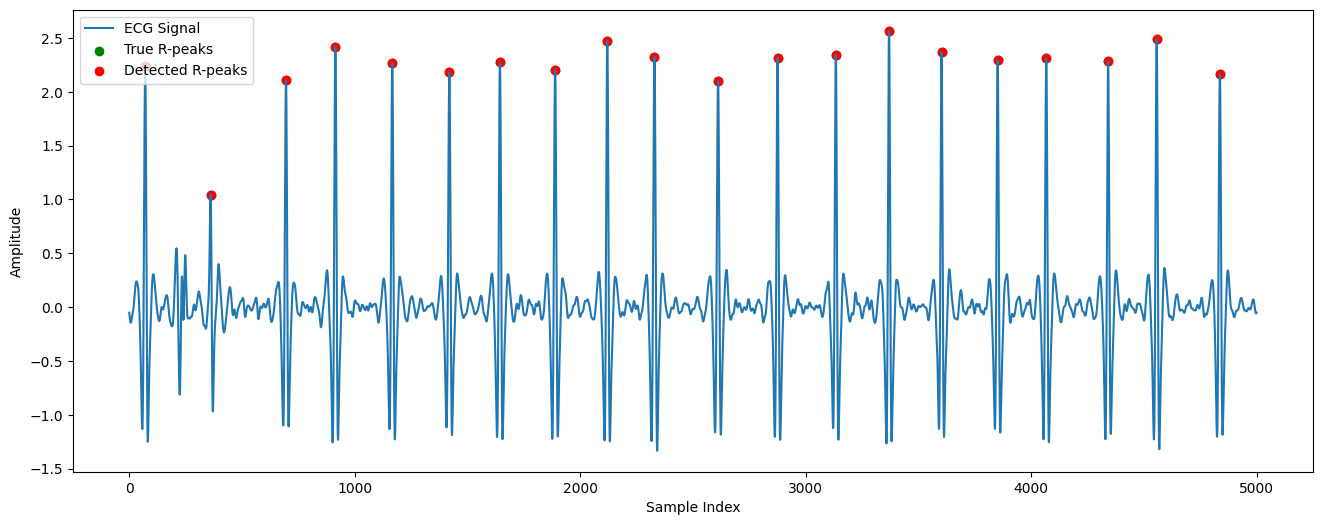

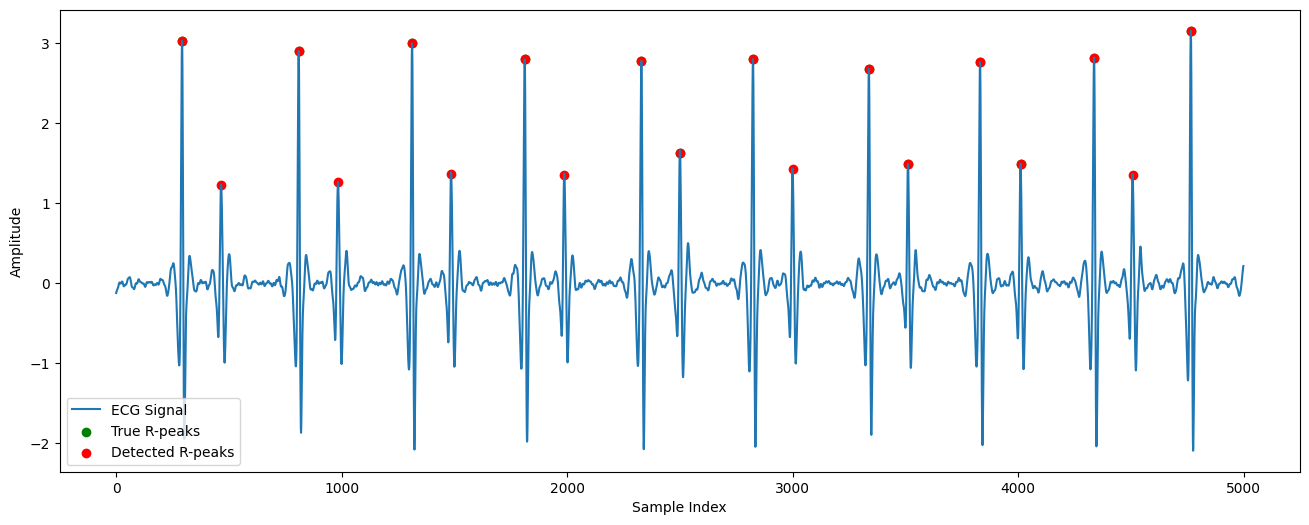

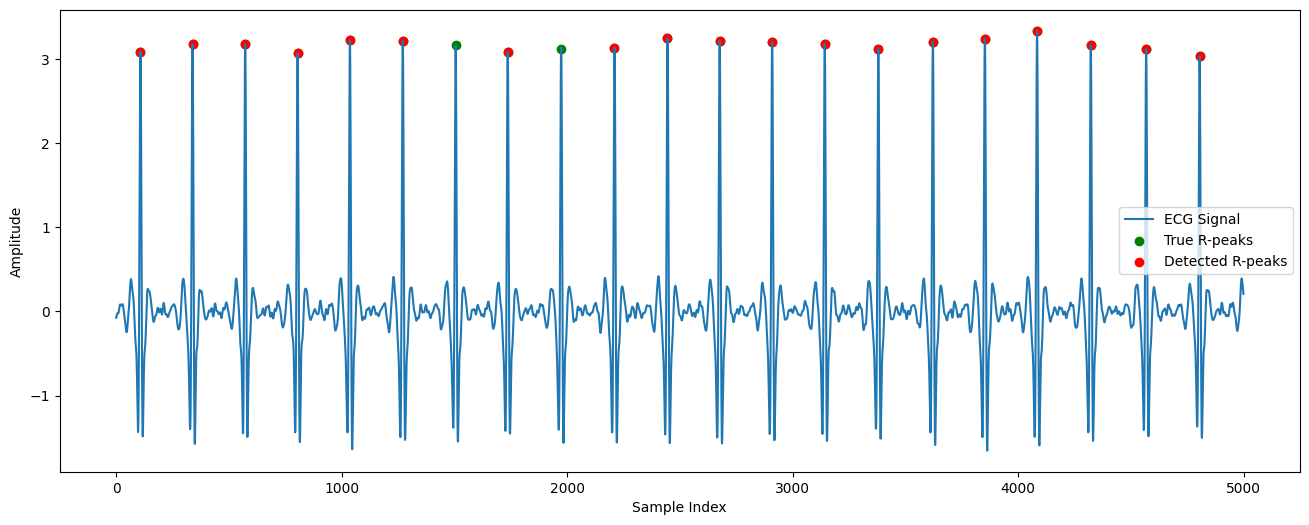

Average Sensitivity: 0.9346
Average Positive Predictivity: 0.9993
Average Accuracy: 0.9340
Average F1 Score: 0.9606


In [14]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin
import matplotlib.pyplot as plt

# 对U-Net模型输出进行二值化
def binarize_output(output, threshold=0.9):
    return (output > threshold).astype(np.float32)

# 自定义DBSCAN算法封装
class CustomDBSCAN(BaseEstimator, ClusterMixin):
    def __init__(self, eps=50, min_samples=1):
        self.eps = eps
        self.min_samples = min_samples
    
    def fit(self, X, y=None):
        self.dbscan_ = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.labels_ = self.dbscan_.fit_predict(X)
        return self

    def fit_predict(self, X, y=None):
        return self.fit(X, y).labels_

# 找到每个聚类的中间点
def find_r_peaks(points, labels):
    r_peaks = []
    for label in np.unique(labels):
        if label == -1:  # 噪声点
            continue
        cluster_points = points[labels == label]
        r_peak = cluster_points[len(cluster_points) // 2]  # 中间点
        r_peaks.append(r_peak[0])
    return r_peaks

# 评估模型性能
def evaluate_performance(true_peaks, detected_peaks, tolerance=75):
    tp = 0
    fp = 0
    fn = 0
    
    for true_peak in true_peaks:
        if any(np.abs(true_peak - detected_peak) <= tolerance for detected_peak in detected_peaks):
            tp += 1
        else:
            fn += 1
    
    for detected_peak in detected_peaks:
        if not any(np.abs(detected_peak - true_peak) <= tolerance for true_peak in true_peaks):
            fp += 1
    
    # 避免分母为零的情况
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    positive_predictivity = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    f1 = 2 * (sensitivity * positive_predictivity) / (sensitivity + positive_predictivity) if (sensitivity + positive_predictivity) > 0 else 0
    
    return sensitivity, positive_predictivity, accuracy, f1

# 创建自定义评分函数
def custom_scorer(estimator, X, y):
    points = np.argwhere(X.flatten() == 1).flatten().reshape(-1, 1)
    if len(points) == 0:
        return 0  # 如果没有点，返回0分
    
    labels = estimator.fit_predict(points)
    detected_peaks = find_r_peaks(points, labels)
    true_peaks = np.argwhere(y.flatten() == 1).flatten()
    
    _, _, accuracy, _ = evaluate_performance(true_peaks, detected_peaks)
    return accuracy

# 准备数据进行参数搜索
model.eval()
X_train = []
y_train = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs).cpu().numpy()
        binary_outputs = binarize_output(outputs)
        
        for i in range(len(inputs)):
            X_train.append(binary_outputs[i][0])
            y_train.append(labels[i][0].cpu().numpy())

X_train = np.array(X_train)
y_train = np.array(y_train)

# 定义参数网格
param_grid = {
    'eps': [30, 40, 50, 60, 70],
    'min_samples': [1, 2, 3, 5]
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(CustomDBSCAN(), param_grid, scoring=make_scorer(custom_scorer), cv=3, verbose=2)

# 执行参数搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# 使用最佳参数进行R峰检测
best_params = grid_search.best_params_
best_dbscan = CustomDBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])

# 使用最佳参数评估模型性能
all_sensitivities = []
all_positive_predictivities = []
all_accuracies = []
all_f1_scores = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs).cpu().numpy()
        binary_outputs = binarize_output(outputs)
        
        for i in range(len(inputs)):
            points = np.argwhere(binary_outputs[i][0].flatten() == 1).flatten().reshape(-1, 1)
            if len(points) == 0:
                continue
            
            cluster_labels = best_dbscan.fit_predict(points)
            detected_peaks = find_r_peaks(points, cluster_labels)
            true_peaks = np.argwhere(labels[i][0].cpu().numpy() == 1).flatten()
            
            sensitivity, positive_predictivity, accuracy, f1 = evaluate_performance(true_peaks, detected_peaks)
            all_sensitivities.append(sensitivity)
            all_positive_predictivities.append(positive_predictivity)
            all_accuracies.append(accuracy)
            all_f1_scores.append(f1)
            
            # 可视化R峰检测（仅可视化前几个样本以避免过多图形）
            if len(all_sensitivities) <= 5:
                visualize_r_peak_detection(inputs[i][0].cpu().numpy(), true_peaks, detected_peaks)

print(f"Average Sensitivity: {np.mean(all_sensitivities):.4f}")
print(f"Average Positive Predictivity: {np.mean(all_positive_predictivities):.4f}")
print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(all_f1_scores):.4f}")


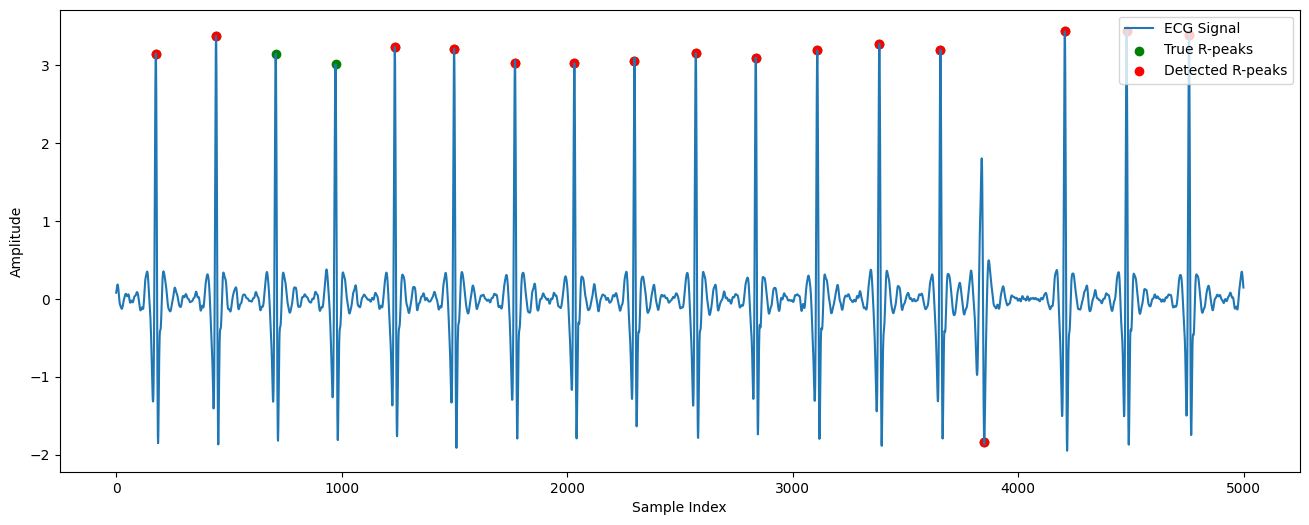

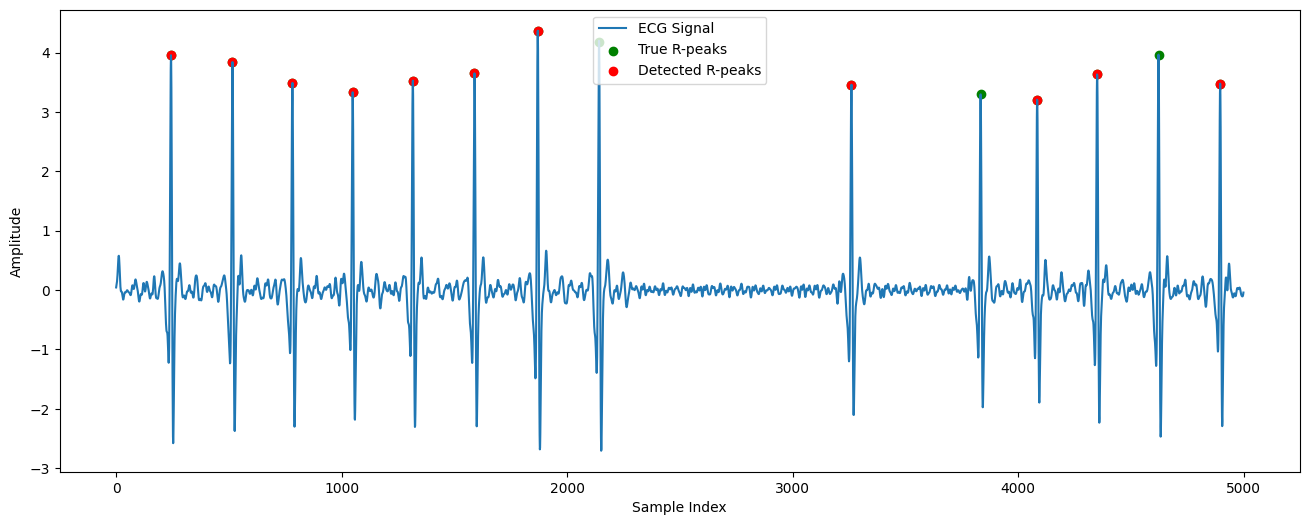

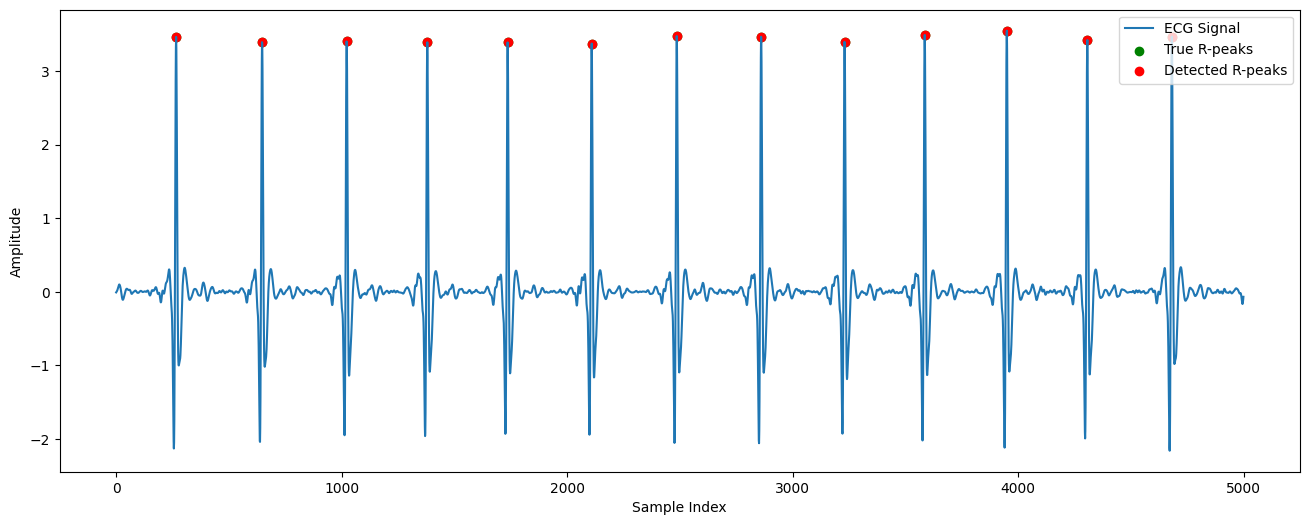

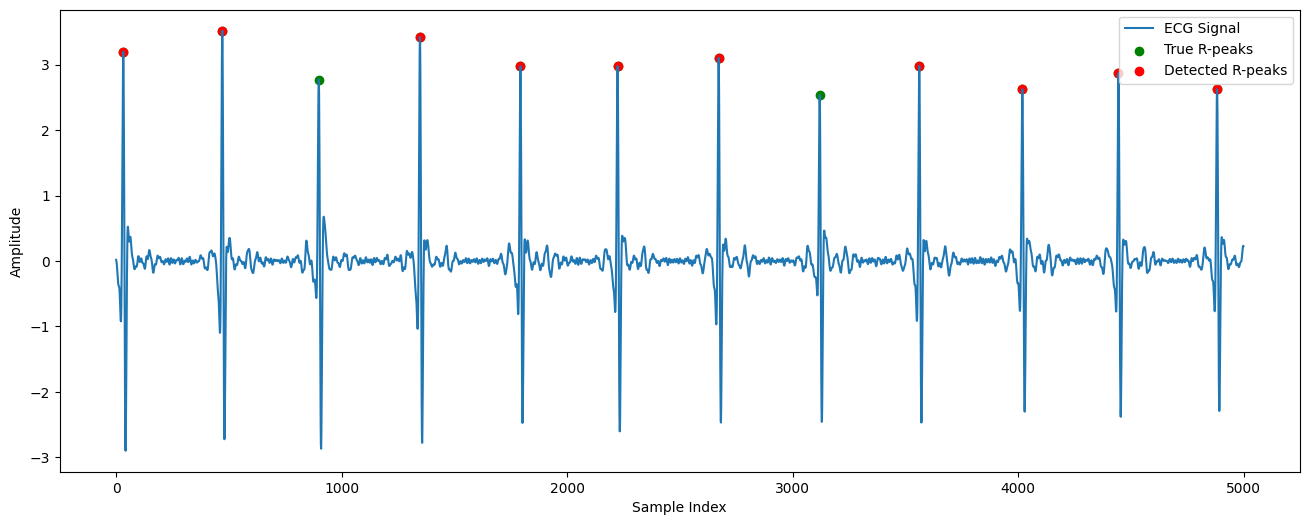

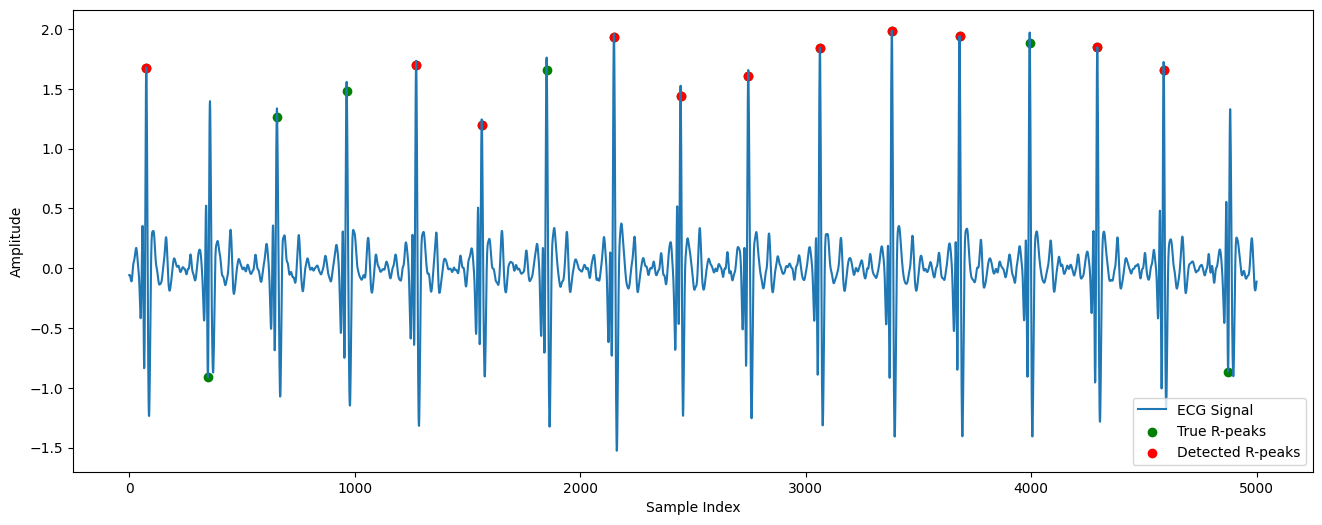

Average Sensitivity: 0.8399
Average Positive Predictivity: 0.9963
Average Accuracy: 0.8389
Average F1 Score: 0.8982


In [24]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 对U-Net模型输出进行二值化
def binarize_output(output, threshold=0.9):
    return (output > threshold).astype(np.float32)

# 使用DBSCAN进行聚类
def apply_dbscan(binary_output, eps=50, min_samples=1):
    # 将二值化输出展开为一维
    points = np.argwhere(binary_output.flatten() == 1).flatten().reshape(-1, 1)
    if len(points) == 0:
        return points, np.array([])  # 返回空结果以避免错误
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(points)
    return points, labels

# 找到每个聚类的中间点
def find_r_peaks(points, labels):
    r_peaks = []
    for label in np.unique(labels):
        if label == -1:  # 噪声点
            continue
        cluster_points = points[labels == label]
        r_peak = cluster_points[len(cluster_points) // 2]  # 中间点
        r_peaks.append(r_peak[0])
    return r_peaks

# 评估模型性能
def evaluate_performance(true_peaks, detected_peaks, tolerance=75):
    tp = 0
    fp = 0
    fn = 0
    
    for true_peak in true_peaks:
        if any(np.abs(true_peak - detected_peak) <= tolerance for detected_peak in detected_peaks):
            tp += 1
        else:
            fn += 1
    
    for detected_peak in detected_peaks:
        if not any(np.abs(detected_peak - true_peak) <= tolerance for true_peak in true_peaks):
            fp += 1
    
    # 避免分母为零的情况
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    positive_predictivity = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    f1 = 2 * (sensitivity * positive_predictivity) / (sensitivity + positive_predictivity) if (sensitivity + positive_predictivity) > 0 else 0
    
    return sensitivity, positive_predictivity, accuracy, f1

# 可视化R峰检测
def visualize_r_peak_detection(signal, true_peaks, detected_peaks):
    plt.figure(figsize=(16, 6))
    plt.plot(signal, label='ECG Signal')
    plt.scatter(true_peaks, signal[true_peaks], color='green', label='True R-peaks')
    plt.scatter(detected_peaks, signal[detected_peaks], color='red', label='Detected R-peaks')
    plt.legend()
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()

# 使用训练好的模型进行预测并评估性能
model.eval()
all_sensitivities = []
all_positive_predictivities = []
all_accuracies = []
all_f1_scores = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs).cpu().numpy()
        binary_outputs = binarize_output(outputs)
        
        for i in range(len(inputs)):
            points, cluster_labels = apply_dbscan(binary_outputs[i][0])
            detected_peaks = find_r_peaks(points, cluster_labels)
            true_peaks = np.argwhere(labels[i][0].cpu().numpy() == 1).flatten()
            
            sensitivity, positive_predictivity, accuracy, f1 = evaluate_performance(true_peaks, detected_peaks)
            all_sensitivities.append(sensitivity)
            all_positive_predictivities.append(positive_predictivity)
            all_accuracies.append(accuracy)
            all_f1_scores.append(f1)
            
            # 可视化R峰检测（仅可视化前几个样本以避免过多图形）
            if len(all_sensitivities) <= 5:
                visualize_r_peak_detection(inputs[i][0].cpu().numpy(), true_peaks, detected_peaks)

print(f"Average Sensitivity: {np.mean(all_sensitivities):.4f}")
print(f"Average Positive Predictivity: {np.mean(all_positive_predictivities):.4f}")
print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(all_f1_scores):.4f}")


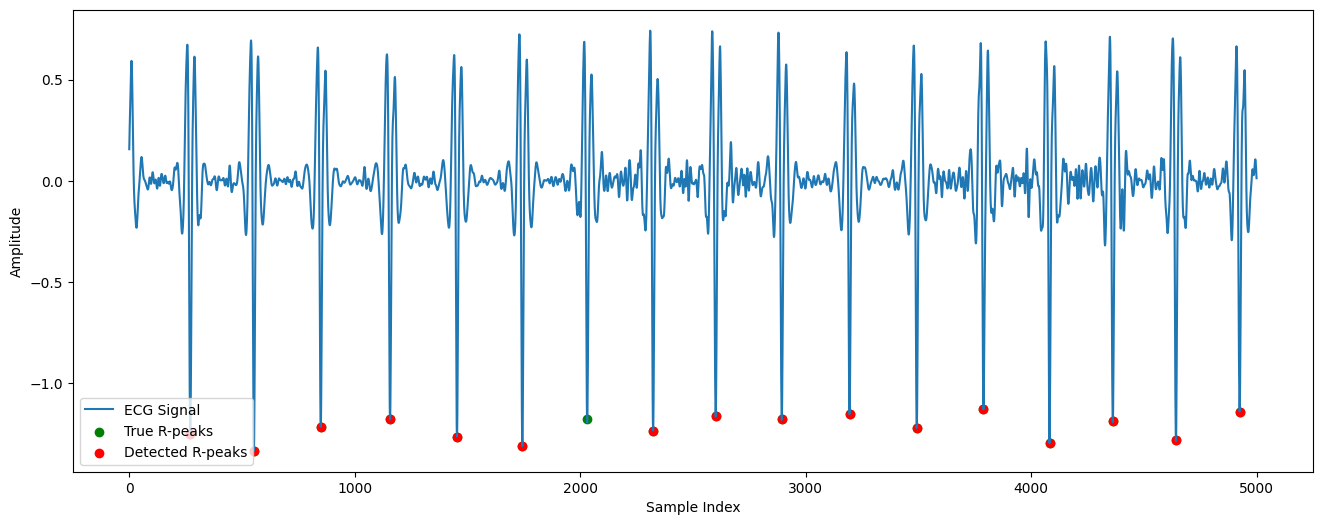

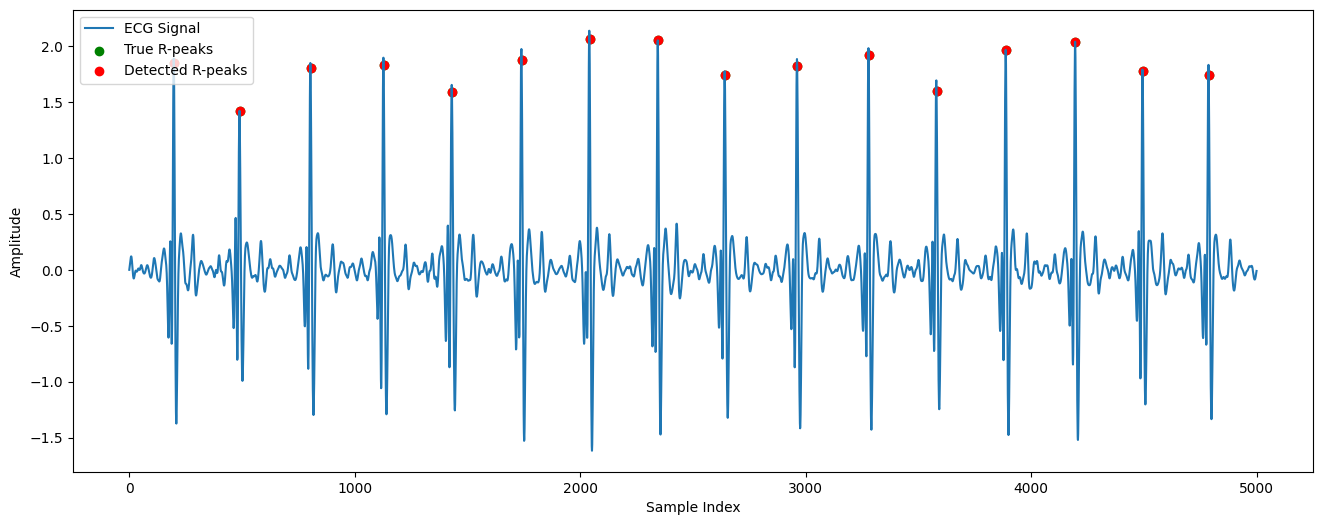

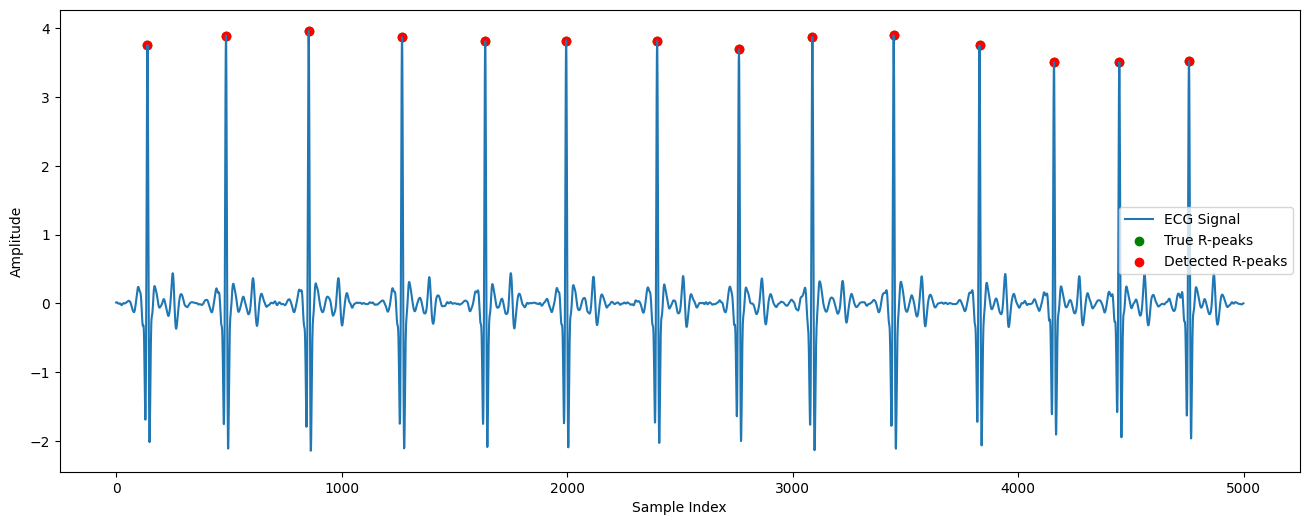

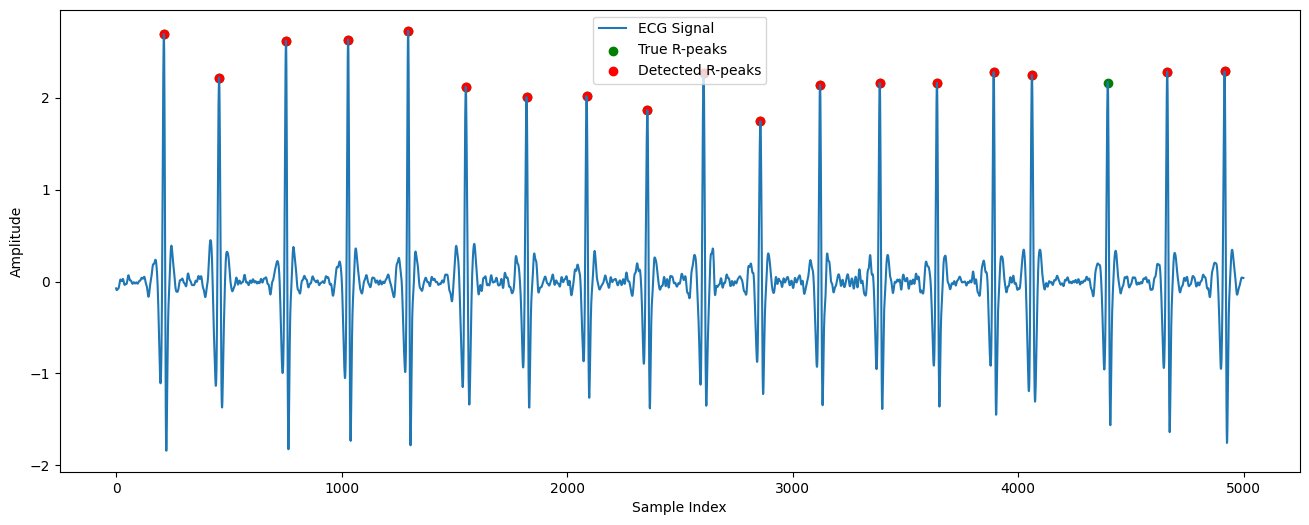

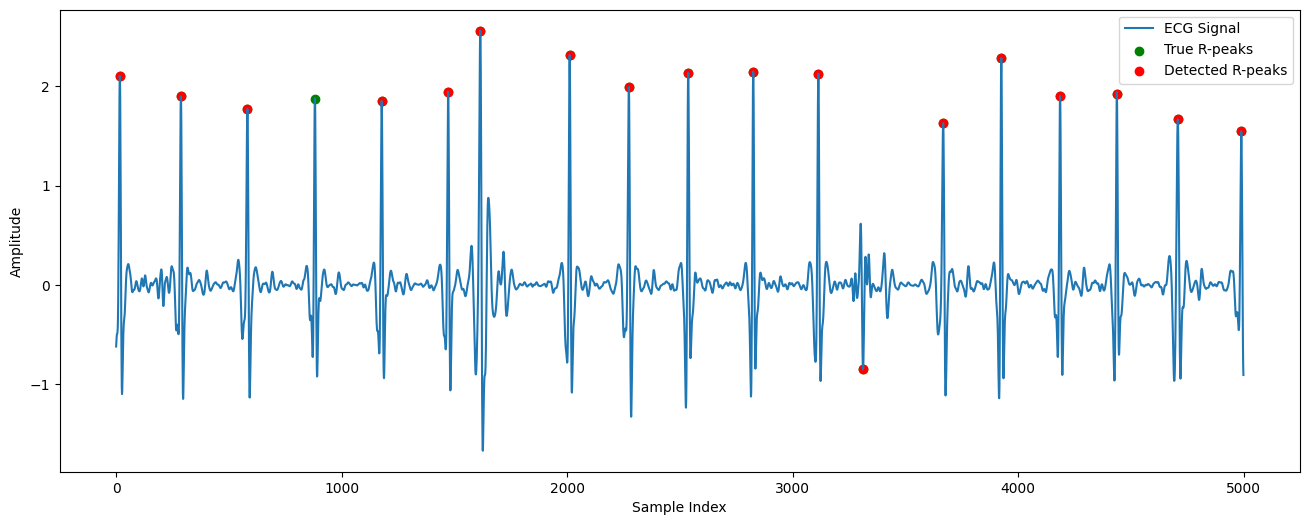

Average Sensitivity: 0.9282
Average Positive Predictivity: 0.9924
Average Accuracy: 0.9276
Average F1 Score: 0.9540


In [13]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 对U-Net模型输出进行二值化
def binarize_output(output, threshold=0.9):
    return (output > threshold).astype(np.float32)

# 使用DBSCAN进行聚类
def apply_dbscan(binary_output, eps=50, min_samples=1):
    # 将二值化输出展开为一维
    points = np.argwhere(binary_output.flatten() == 1).flatten().reshape(-1, 1)
    if len(points) == 0:
        return points, np.array([])  # 返回空结果以避免错误
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(points)
    return points, labels

# 找到每个聚类的中间点
def find_r_peaks(points, labels):
    r_peaks = []
    for label in np.unique(labels):
        if label == -1:  # 噪声点
            continue
        cluster_points = points[labels == label]
        r_peak = cluster_points[len(cluster_points) // 2]  # 中间点
        r_peaks.append(r_peak[0])
    return r_peaks

# 评估模型性能
def evaluate_performance(true_peaks, detected_peaks, tolerance=75):
    tp = 0
    fp = 0
    fn = 0
    
    for true_peak in true_peaks:
        if any(np.abs(true_peak - detected_peak) <= tolerance for detected_peak in detected_peaks):
            tp += 1
        else:
            fn += 1
    
    for detected_peak in detected_peaks:
        if not any(np.abs(detected_peak - true_peak) <= tolerance for true_peak in true_peaks):
            fp += 1
    
    # 避免分母为零的情况
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    positive_predictivity = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    f1 = 2 * (sensitivity * positive_predictivity) / (sensitivity + positive_predictivity) if (sensitivity + positive_predictivity) > 0 else 0
    
    return sensitivity, positive_predictivity, accuracy, f1

# 可视化R峰检测
def visualize_r_peak_detection(signal, true_peaks, detected_peaks):
    plt.figure(figsize=(16, 6))
    plt.plot(signal, label='ECG Signal')
    plt.scatter(true_peaks, signal[true_peaks], color='green', label='True R-peaks')
    plt.scatter(detected_peaks, signal[detected_peaks], color='red', label='Detected R-peaks')
    plt.legend()
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()

# 使用训练好的模型进行预测并评估性能
model.eval()
all_sensitivities = []
all_positive_predictivities = []
all_accuracies = []
all_f1_scores = []

# DBSCAN参数
dbscan_eps = 20
dbscan_min_samples = 1

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs).cpu().numpy()
        binary_outputs = binarize_output(outputs)
        
        for i in range(len(inputs)):
            points, cluster_labels = apply_dbscan(binary_outputs[i][0], eps=dbscan_eps, min_samples=dbscan_min_samples)
            detected_peaks = find_r_peaks(points, cluster_labels)
            true_peaks = np.argwhere(labels[i][0].cpu().numpy() == 1).flatten()
            
            sensitivity, positive_predictivity, accuracy, f1 = evaluate_performance(true_peaks, detected_peaks)
            all_sensitivities.append(sensitivity)
            all_positive_predictivities.append(positive_predictivity)
            all_accuracies.append(accuracy)
            all_f1_scores.append(f1)
            
            # 可视化R峰检测（仅可视化前几个样本以避免过多图形）
            if len(all_sensitivities) <= 5:
                visualize_r_peak_detection(inputs[i][0].cpu().numpy(), true_peaks, detected_peaks)

print(f"Average Sensitivity: {np.mean(all_sensitivities):.4f}")
print(f"Average Positive Predictivity: {np.mean(all_positive_predictivities):.4f}")
print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Average F1 Score: {np.mean(all_f1_scores):.4f}")
